## FPE Programming Assignment (15 Marks)

### Implement the technique proposed in the paper "Penalizing Unfairness in Binary Classification" and reproduce the experimental results

    - Find the paper here: https://arxiv.org/pdf/1707.00044.pdf
    

(6 marks) Reproduce the results shown in Table-1
        
           You need to implement the proposed method with AVD Penalizers and reproduce results for COMPAS dataset for all three Considerations shown in the table. Furthermore, you need to compare the above results with Zafar et al. and Zafar et al. Baseline for all three Considerations shown in the Table-1.
           
           
(4 marks) Reproduce the results shown in Table-3
          
           You need to implement the proposed method with AVD Penalizers and Vanilla Regularized Logistic Regression, and reproduce results for all three datasets mentioned in the Table-3.

          
(5 marks) Reproduce the results shown in Figure-2 and 3
          
           You need to reproduce the plots shown in Figure-2 (COMPAS dataset) and Figure-3 (Adult Dataset).

Note: All the experiments and details have to be clearly explained
      
      
#### Kindly complete the code in the following notebook itself.

#### The soft deadline for submission is 15th Nov. The hard deadline for submission is 28th Nov. with 20% penalty.

In [1]:
import numpy as np
import pandas as pd
np.random.seed(42)

---

# Formulating the problem in CVXPY

For the logistic regression problem we need to find $w \in R^{dim_X}$ which minimizes the following loss for our model, along with corresponding fairness penalties with $d_1$ and $d_2$ set-up according to desired tradeoff b/w accuracy, FPR matching and FNR matching.

$$\begin{align}
\text{Objective: } &\text{minimize}_{\theta} &&L_S^{0-1}(\theta) + d_1 \textbf{D}_1 + d_2 \textbf{D}_2
\end{align}$$

Relaxed form of this loss (with additional $\ell_2$ regularization term) gives us the formulation:
$$\begin{align}
\text{Proxy:} &\text{minimize}&& - \ell\ell(\theta;S) + c_1R_{FP}(\theta;S) + c_2R_{FN}(\theta;S) + q \| \theta \|^2.
\end{align}$$
 where $\ell\ell$ is:
 $$\ell\ell(\theta;S) = \sum\limits_{i=1}^{i=|S|} y_1 \theta^Tx_i - log(1+exp(\theta^Tx_i))$$

### REDACTED
Note: Paper specifies 5-fold cross validation on the train dataset S available, but 
their implementation conforms with repeated cross-validation, specifically 5 2-fold
cross validation (with validation size 0.5). have opted for the repeated cross-validation which better represents the observations.

Rather, we have a *Shuffle split* system which samples our train and test sets for  validation at random for `num` times.
Link: https://amueller.github.io/aml/04-model-evaluation/1-data-splitting-strategies.html

##### Note

The *vanilla version* of this problem is already being solved by the above function (when $val_c := 0$).

## Subpopulations Utils

$$S_{a, y} = \{x^i \in S: x_1^i = a, y^i = y\} \quad \text{for } a, y \in \{0, 1\}$$ 

In [2]:
S = [[0, 0], [0, 0]]
S[0][0] = lambda dataset, labels: dataset[np.where(
    (dataset[:, 0] == 0) & (labels == 0))]
S[0][1] = lambda dataset, labels: dataset[np.where(
    (dataset[:, 0] == 0) & (labels == 1))]
S[1][0] = lambda dataset, labels: dataset[np.where(
    (dataset[:, 0] == 1) & (labels == 0))]
S[1][1] = lambda dataset, labels: dataset[np.where(
    (dataset[:, 0] == 1) & (labels == 1))]


## Absolute Value Difference Penalty

$$R_{FP}^{AVD}(\theta;S) = \left| {\theta}^T \left(\dfrac {\sum\limits_{x \in S_{00}} x} { |S_{00}| } -  \dfrac {\sum\limits_{x \in S_{10}} x} { |S_{10}| }\right) \right|$$

In [3]:
R = {'AVD':{}, 'SD':{}}
eps=1e-9
R['AVD']['FP'] = lambda S00, S01, theta: np.abs(theta.T @ ((np.sum(S00,axis=0) / (eps+S00.shape[0])) - (np.sum(S01,axis=0) / (eps+S01.shape[0]))))
R['AVD']['FN'] = lambda S10, S11, theta: np.abs(theta.T @ ((np.sum(S10,axis=0) / (eps+S10.shape[0])) - (np.sum(S11,axis=0) / (eps+S11.shape[0]))))

R['SD']['FP'] = lambda S00, S01, theta: (R['AVD']['FP'](S00, S01, theta))**2
R['SD']['FN'] = lambda S10, S11, theta: (R['AVD']['FN'](S10, S11, theta))**2

In [4]:
def solve_problem_instance(X, y, c_1, c_2, gamma, squared=False):
    import cvxpy as cp
    import numpy as np
    """
    minimize log-likelihood + c_1 R_FP [**2] + c_2 R_FN [**2] + gamma \|theta\|^2_2
    returns: w
    """
    w = cp.Variable(X.shape[1])
    
    # Generate S for given dataset
    #S_ay -> protected attribute = a, label = y
    instanceS = [[0,0], [0,0]]
    instanceS[0][0] = S[0][0](X, y)
    instanceS[0][1] = S[0][1](X, y)
    instanceS[1][0] = S[1][0](X, y)
    instanceS[1][1] = S[1][1](X, y)
    eps = 1e-9
    if squared == False:
        R_FN = cp.abs(w.T @ ((np.sum(instanceS[1][1],axis=0) / (eps + instanceS[1][1].shape[0])) - (np.sum(instanceS[0][1],axis=0) / (eps + instanceS[0][1].shape[0]))))
        R_FP = cp.abs(w.T @ ((np.sum(instanceS[1][0],axis=0) / (eps + instanceS[1][0].shape[0])) - (np.sum(instanceS[0][0],axis=0) / (eps + instanceS[0][0].shape[0]))))
    else:
        R_FP = cp.square(w.T @ ((np.sum(instanceS[1][0],axis=0) / (eps + instanceS[1][0].shape[0])) - (np.sum(instanceS[0][0],axis=0) / (eps + instanceS[0][0].shape[0]))))
        R_FN = cp.square(w.T @ ((np.sum(instanceS[1][1],axis=0) / (eps + instanceS[1][1].shape[0])) - (np.sum(instanceS[0][1],axis=0) / (eps + instanceS[0][1].shape[0]))))
    l2_norm_sq = cp.sum_squares(w)
    # logloss = y.T * (X * w) - cp.sum(cp.logistic(X * w))
    logloss = y.T @ (X @ w) - cp.sum(cp.logistic(X @ w))
    prob = cp.Problem(cp.Minimize(-logloss + c_1 * R_FP + c_2 * R_FN + gamma * l2_norm_sq))
    prob.solve(solver='ECOS', verbose=False ,max_iters=1000)
    
    return {
        'w': w.value,
        'll': logloss.value,
        'fpr_diff': R_FP.value,
        'fnr_diff': R_FN.value,
        'loss': -1 * logloss.value + c_1 * R_FP.value + c_2 * R_FN.value
    }

## Disparity b/w groups

> Evaluated on the test set.


### FPR

$$\textbf{D}_{FPR} = |FPR_{a=0}(\hat{Y}) - FPR_{a=1}(\hat{Y})|$$

### FNR

$$\textbf{D}_{FNR} = |FNR_{a=0}(\hat{Y}) - FNR_{a=1}(\hat{Y})|$$


In [5]:
eps=1e-9
fpr = lambda y, yhat: yhat.T @ (np.ones(y.shape) - y) / (eps + np.sum(np.ones(y.shape) - y))
fnr = lambda y, yhat: (np.ones(y.shape) - yhat).T @ y / (eps + np.sum(y))
Disparity = {}
Disparity['fpr'] = lambda ya, yhata, yb, yhatb: np.abs(fpr(ya, yhata)- fpr(yb, yhatb)) 
Disparity['fnr'] = lambda ya, yhata, yb, yhatb: np.abs(fnr(ya, yhata)- fnr(yb, yhatb)) 

In [6]:
def stats(y, yhat):
    ones = np.ones(y.shape)
    # fpr = lambda y, yhat: yhat.T @ (ones - y) / np.sum(ones - y)
    # fnr = lambda y, yhat: (ones - yhat).T @ y / np.sum(y)
    acc = lambda y, yhat: (np.sum(yhat.T @ y) + np.sum((ones - yhat).T @ (ones - y))) / y.shape[0]
    
    return {'fpr': (fpr(y, yhat)).item(),
            'fnr': (fnr(y, yhat)).item(),
            'acc': (acc(y, yhat)).item()}

In [7]:
def eval_stats(X, y, c1, c2, gamma, w, squared=False):
    """
    Evaluate model `w` on dataset (X,y) based on objective and relaxed loss scores
    returns: Dict(model=)
    """
    yhat = np.round(1 / (1 + np.exp(-(X @ w).astype(float))))
    a = np.where(X[:, 0] == 0)
    b = np.where(X[:, 0] == 1)

    actual_fpr_diff = Disparity['fpr'](y[a], yhat[a], y[b], yhat[b])
    actual_fnr_diff = Disparity['fnr'](y[a], yhat[a], y[b], yhat[b])
    actual_stats = stats(y, yhat)

    instanceS = [[0, 0], [0, 0]]
    instanceS[0][0] = S[0][0](X, y)
    instanceS[0][1] = S[0][1](X, y)
    instanceS[1][0] = S[1][0](X, y)
    instanceS[1][1] = S[1][1](X, y)

    R_FN = R['AVD' if not squared else 'SD']['FP'](instanceS[1][1], instanceS[0][1], w)
    R_FP = R['AVD' if not squared else 'SD']['FN'](instanceS[1][0], instanceS[0][0], w)

    logloss = y.T @ (X @ w) - np.sum(np.log(1+np.exp((X @ w).astype(float))))

    return {
        'objective': {
            'accuracy': actual_stats['acc'],
            'fpr': actual_stats['fpr'],
            'fnr': actual_stats['fnr'],
            'fpr_diff': actual_fpr_diff,
            'fnr_diff': actual_fnr_diff,
            'loss': (1 - actual_stats['acc']) + (actual_fpr_diff if c1 > 0 else 0) + (actual_fnr_diff if c2 > 0 else 0),
        },
        'relaxed': {
            'fnr_diff': R_FN.item(),
            'fpr_diff': R_FP.item(),
            'll': logloss.item(),  # logistic loss,
            'loss': (-logloss + c1 * R_FP + c2 * R_FN).item(),
        },
    }


# AVD Penalizers Method 

> Given $d_0$ and $d_1$.

1. Split dataset at random into training set $S$ and test set $T$.
2. For each $c$ in some range, perform **cross-validation** on $S$ to select the corresponding best value $q_c$ for the regularization parameter.
3. For each $(c, q_c)$, let $$\theta_c = \text{argmin}_{\theta}\text{ Proxy}(\theta;S,c, c,q_c)$$
4. Select $\theta^* \in \text{argmin}_{\theta_C} \text{ Objective}(\theta_c;S,d_1,d_2)$
5. Evaluate performance on test set $T$.
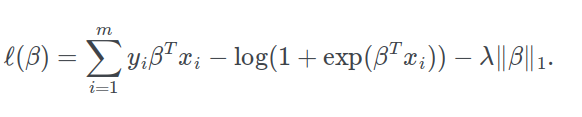

In [8]:
from tqdm.notebook import tqdm


def solve_problem(X, y, problem):
    """ Solve the optimization problem as defined in the paper: https://arxiv.org/pdf/1707.00044.pdf"""
    from sklearn.model_selection import train_test_split

    range_c = np.linspace(
        problem['c'][0], problem['c'][1], num=problem['c'][2])
    range_gamma = np.linspace(
        problem['gamma'][0], problem['gamma'][1], num=problem['gamma'][2])

    # 1. Done
    X_train_all, X_test_all, y_train_all, y_test_all = train_test_split(
        X, y, test_size=problem['test_size'], random_state=42)

    # For a given val_c, stores model stats for
    results_all = [[] for _ in range(problem['c'][2])]

    
    optimal_gamma_map = {c: 0 for c in range_c}

    # Finding optimal gamma for every `c` there can be
    assert (problem['fn'] == True or problem['fp'] == True)

    for i, val_c in tqdm(enumerate(range_c), total=len(range_c)):
        tmp_gamma_results = [[] for _ in range(problem['gamma'][2])]
        for fold in range(problem['folds']):
            # set random state variable for different folds
            x_train_val, x_test_val, y_train_val, y_test_val = train_test_split(
                X_train_all, y_train_all, test_size=problem['validation_size'], random_state=i*10)

            # Solve problem for all gammas
            for idx, val_gamma in enumerate(range_gamma):
                try:
                    solution = solve_problem_instance(x_train_val, y_train_val, float(val_c if problem['fp'] == True else 0),
                                                    float(
                                                        val_c if problem['fn'] == True else 0), val_gamma,
                                                    squared=problem['fair_penalty'] != 'AVD')
                    # Store all the stats, D_FP, D_TP, Accuracy
                    # Evaluate on the validation-held out set i.e. test set
                    tmp_gamma_results[idx] += [eval_stats(x_test_val, y_test_val, float(val_c if problem['fp'] == True else 0), float(
                        val_c if problem['fn'] == True else 0), val_gamma, solution['w'], squared=problem['fair_penalty'] != 'AVD')]
                except Exception as e:
                    # print(e)
                    print(f"Solver fails for c:{val_c} and gamma:{val_gamma}")
                    pass

        avg_cross_validation_results = np.array([np.average([res_gamma_valc['objective' if val_c >= 0.001 else 'relaxed']['loss']
                                                for res_gamma_valc in tmp_gamma_results[idx]]) for idx in range(len(tmp_gamma_results))])

        # Find optimal gamma for this particular C from the fold results
        optimal_index = avg_cross_validation_results.argmin()
        optimal_gamma_map[val_c] = range_gamma[optimal_index]
        
        # Test the trained model
        try:
            best_model_c = solve_problem_instance(X_train_all, y_train_all, float(val_c if problem['fp'] == True else 0),
                                                float(
                val_c if problem['fn'] == True else 0), optimal_gamma_map[val_c], squared=problem['fair_penalty'] != 'AVD')

            results_all[i] = eval_stats(X_test_all, y_test_all, float(val_c if problem['fp'] == True else 0),
                                        float(
                val_c if problem['fn'] == True else 0), optimal_gamma_map[val_c], best_model_c['w'], squared=problem['fair_penalty'] != 'AVD')
        except Exception as e:
            # print(e)
            print(f"Optimal model solver failed for c: {val_c}")
            pass

    # # From all the models, choose the one performing best on objective loss over test set T.
    # best_model_idx= np.array([res['objective']['accuracy'] for res in results_all]).argmin()

    return results_all


In [9]:
def solve(X, y, problem):
    """ For a given labelled dataset (X, y), solve for best w """
    results = {
        'Vanilla': {
            'accuracy': 0,
            'fpr_diff': 0,
            'fnr_diff': 0,
            'relaxed_fpr_diff': 0,
            'relaxed_fnr_diff': 0,
        },
        'AVD': {
            'accuracy': [],
            'fpr_diff': [],
            'fnr_diff': [],
            'relaxed_fpr_diff': [],
            'relaxed_fnr_diff': []
        },
        'SD': {
            'accuracy': [],
            'fpr_diff': [],
            'fnr_diff': [],
            'relaxed_fpr_diff': [],
            'relaxed_fnr_diff': []
        }
    }

    for it in range(problem['nruns']):
        problem['fair_penalty'] = 'AVD'
        avd_results = solve_problem(X, y, problem)
        assert(len(avd_results) > 0)
        results['Vanilla']['accuracy'] += avd_results[0]['objective']['accuracy']
        results['Vanilla']['fpr_diff'] += avd_results[0]['objective']['fpr_diff']
        results['Vanilla']['fnr_diff'] += avd_results[0]['objective']['fnr_diff']
        results['Vanilla']['relaxed_fpr_diff'] += avd_results[0]['relaxed']['fpr_diff']
        results['Vanilla']['relaxed_fnr_diff'] += avd_results[0]['relaxed']['fnr_diff']


        for idx in range(len(avd_results)):
            assert (avd_results[idx]['objective']['accuracy'] <=1)
            results['AVD']['accuracy'] += [avd_results[idx]['objective']['accuracy']]
            assert (avd_results[idx]['objective']['fpr_diff'] <=1)
            results['AVD']['fpr_diff'] += [avd_results[idx]['objective']['fpr_diff']]
            assert (avd_results[idx]['objective']['fnr_diff'] <=1)
            results['AVD']['fnr_diff'] += [avd_results[idx]['objective']['fnr_diff']]
            assert (avd_results[idx]['relaxed']['fpr_diff'] <=1)
            results['AVD']['relaxed_fpr_diff'] += [avd_results[idx]['relaxed']['fpr_diff']]
            assert (avd_results[idx]['relaxed']['fpr_diff'] <=1)
            results['AVD']['relaxed_fnr_diff'] += [avd_results[idx]['relaxed']['fnr_diff']]

        problem['fair_penalty'] = 'SD'
        sd_results = solve_problem(X, y, problem)

        for idx in range(len(sd_results)):
            results['SD']['accuracy'] += [sd_results[idx]['objective']['accuracy']]
            results['SD']['fpr_diff'] += [sd_results[idx]['objective']['fpr_diff']]
            results['SD']['fnr_diff'] += [sd_results[idx]['objective']['fnr_diff']]
            results['SD']['relaxed_fpr_diff'] += [sd_results[idx]['relaxed']['fpr_diff']]
            results['SD']['relaxed_fnr_diff'] += [sd_results[idx]['relaxed']['fnr_diff']]
    
    for key in results['Vanilla'].keys():
        results['Vanilla'][key] /= problem['nruns']

    for key in results['AVD'].keys():
        results['AVD'][key] = np.array(results['AVD'][key])
        temp = results['AVD'][key].reshape(problem['nruns'],-1)
        results['AVD'][key] = np.sum(temp, axis=0)
        results['AVD'][key] /= problem['nruns']

    for key in results['SD'].keys():
        results['SD'][key] = np.array(results['SD'][key])
        temp = results['SD'][key].reshape(problem['nruns'],-1)
        results['SD'][key] = np.sum(temp, axis=0)
        results['SD'][key] /= problem['nruns']

    return results

----

---


# PART 1

## Data Preprocessing

### COMPAS

In [10]:
def process_data(df, data_extract, transform):
    """ 
    Parse the dataset according to data_extract 
    returns: X[:], y[:] where X are the stacked input variables (with x_1 being protected) and y is the corresponding label 
    """

    for header in transform.keys():
        df[header].replace(transform[header], inplace=True)
    X = df[[*data_extract['input_columns']]]
    y = df[[data_extract['label_column']]]

    for header in X.columns:
        numeric_values =  pd.to_numeric(X[header], errors='coerce').notnull()
        X = X[numeric_values]
        y = y[numeric_values]
    
    numeric_values = pd.to_numeric(y[data_extract['label_column']], errors='coerce').notnull()
    X = X[numeric_values]
    y = y[numeric_values]

    X = X.values
    y = y.values.reshape(-1,)
    return X.astype(float), y.astype(float)

In [11]:
dataset = {}
# Stores only the real values, use association to interpret the output
dataset['compas'] = pd.read_csv('dataset/compas/compas-scores-two-years.csv')
# dataset['compas']

### Mapping input space to Reals 

#### COMPAS Dataset

In [12]:
transform = {}
transform['compas'] = {
    'race': {
      'Caucasian': 0,
      'African-American': 1
    },
    'sex': {
        'Male': 0,
        'Female': 1,
    },
    'c_charge_degree': {
        'M': 0,
        'F': 1
    },
}

#### Input variables extraction


In [13]:
fmt = {}
fmt['compas'] = {
    # 5 features where 1st feature is the protected attribute
    'input_columns': ['race','age','sex','priors_count','c_charge_degree'], 
    'label_column': 'two_year_recid',
}

#### Set default problem parameters

In [14]:
problem = {}
problem['compas'] = {
    'c': (0, 400, 21),# 21
    'gamma': (0, 100, 11),
    'validation_size': 0.5,
    'folds': 5,
    'fp': False,
    'fn': False,
    'test_size': 0.3,
    'nruns': 5
}

In [16]:
X_compas, y_compas = process_data(dataset['compas'], fmt['compas'], transform['compas'])
X_compas.shape

/tmp/ipykernel_17715/3429013367.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[header].replace(transform[header], inplace=True)


(6150, 5)

In [17]:
RES = {
    'AVD':{'FPR': {}, 'FNR': {}, 'Both': {}},
    'SD': {'FPR': {}, 'FNR': {}, 'Both': {}},
    'Vanilla': {'FPR': {}, 'FNR': {}, 'Both': {}}
}

## FPR & FNR Considerations

### Only FPR

- $d_0 = 1$, $d_1$ = 0. Thus only activating $c_1$.

In [34]:
problem['compas']['fn']=False
problem['compas']['fp']=True

## Solve the problem
compas_results = solve(X_compas, y_compas, problem['compas'])


  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

In [65]:
best_model_idx = {}
best_model_idx['AVD'] = 0
best_model_idx['SD'] = 0

loss = {
    'AVD': [],
    'SD': []
}

for i in range(len(compas_results['AVD']['accuracy'])):
    loss['AVD'] += [compas_results['AVD']['accuracy'][i] + compas_results['AVD']['fpr_diff'][i]]

for i in range(len(compas_results['SD']['accuracy'])):
    loss['SD'] += [compas_results['SD']['accuracy'][i] + compas_results['SD']['fpr_diff'][i]]

loss['AVD'] = np.array(loss['AVD'])
loss['SD'] = np.array(loss['SD'])

best_model_idx['AVD'] = loss['AVD'].argmin()
best_model_idx['SD'] = loss['SD'].argmin()

In [66]:

RES['AVD']['FPR'] = {
    'accuracy': compas_results['AVD']['accuracy'][best_model_idx['AVD']],
    'fpr_diff': compas_results['AVD']['fpr_diff'][best_model_idx['AVD']],
    'fnr_diff': compas_results['AVD']['fnr_diff'][best_model_idx['AVD']],
}
RES['SD']['FPR'] = {
    'accuracy': compas_results['SD']['accuracy'][best_model_idx['SD']],
    'fpr_diff': compas_results['SD']['fpr_diff'][best_model_idx['SD']],
    'fnr_diff': compas_results['SD']['fnr_diff'][best_model_idx['SD']],
}

RES['Vanilla']['FPR'] = RES['Vanilla']['FNR'] = RES['Vanilla']['Both'] = {
    'accuracy': compas_results['Vanilla']['accuracy'],
    'fpr_diff': compas_results['Vanilla']['fpr_diff'],
    'fnr_diff': compas_results['Vanilla']['fnr_diff'],
}


In [67]:
print("-----------AVD--------------")
print(RES['AVD']['FPR'])

print("-----------SD--------------")
print(RES['SD']['FPR'])

print("-----------Vanilla--------------")
print(RES['Vanilla']['FPR'])

-----------AVD--------------
{'accuracy': 0.6476964769647696, 'fpr_diff': 0.004710161824371589, 'fnr_diff': 0.033117786788876336}
-----------SD--------------
{'accuracy': 0.6601626016260163, 'fpr_diff': 0.04944186066230556, 'fnr_diff': 0.10399021042781398}
-----------Vanilla--------------
{'accuracy': 0.6655826558265583, 'fpr_diff': 0.20552161544559996, 'fnr_diff': 0.3885056505986516}


### Only FNR 

In [37]:
problem['compas']['fn']=True
problem['compas']['fp']=False


## Solve the problem
compas_results_fnr = solve(X_compas, y_compas, problem['compas'])



  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

In [68]:
best_model_idx = {}
best_model_idx['AVD'] = 0
best_model_idx['SD'] = 0

loss_fnr = {
    'AVD': [],
    'SD': []
}

for i in range(len(compas_results_fnr['AVD']['accuracy'])):
    loss_fnr['AVD'] += [compas_results_fnr['AVD']['accuracy'][i] + compas_results_fnr['AVD']['fnr_diff'][i]]

for i in range(len(compas_results_fnr['AVD']['accuracy'])):
    loss_fnr['SD'] += [compas_results_fnr['SD']['accuracy'][i] + compas_results_fnr['SD']['fnr_diff'][i]]

loss_fnr['AVD'] = np.array(loss_fnr['AVD'])
loss_fnr['SD'] = np.array(loss_fnr['SD'])

best_model_idx['AVD'] = loss_fnr['AVD'].argmin()
best_model_idx['SD'] = loss_fnr['SD'].argmin()

In [69]:

RES['AVD']['FNR'] = {
    'accuracy': compas_results_fnr['AVD']['accuracy'][best_model_idx['AVD']],
    'fpr_diff': compas_results_fnr['AVD']['fpr_diff'][best_model_idx['AVD']],
    'fnr_diff': compas_results_fnr['AVD']['fnr_diff'][best_model_idx['AVD']],
}
RES['SD']['FNR'] = {
    'accuracy': compas_results_fnr['SD']['accuracy'][best_model_idx['SD']],
    'fpr_diff': compas_results_fnr['SD']['fpr_diff'][best_model_idx['SD']],
    'fnr_diff': compas_results_fnr['SD']['fnr_diff'][best_model_idx['SD']],
}


In [70]:
print("-----------AVD--------------")
print(RES['AVD']['FNR'])

print("-----------SD--------------")
print(RES['SD']['FNR'])

-----------AVD--------------
{'accuracy': 0.6368563685636857, 'fpr_diff': 0.014414536636240677, 'fnr_diff': 0.00878782062048622}
-----------SD--------------
{'accuracy': 0.6536585365853659, 'fpr_diff': 0.04148842809477982, 'fnr_diff': 0.08536482952227853}


### Both FPR and FNR

- $d_0 = 1$, $d_1 = 1$. Thus, activating $c_1 = c_2 = c$.

In [43]:
problem['compas']['fn']=True
problem['compas']['fp']=True

compas_results_both = solve(X_compas, y_compas, problem['compas'])
 

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

In [71]:
best_model_idx = {}
best_model_idx['AVD'] = 0
best_model_idx['SD'] = 0

loss_both = {
    'AVD': [],
    'SD': []
}

for i in range(len(compas_results_both['AVD']['accuracy'])):
    loss_both['AVD'] += [compas_results_both['AVD']['accuracy'][i] +
                         compas_results_both['AVD']['fpr_diff'][i] + compas_results_both['AVD']['fnr_diff'][i]]

for i in range(len(compas_results_both['SD']['accuracy'])):
    loss_both['SD'] += [compas_results_both['SD']['accuracy'][i] +
                        compas_results_both['SD']['fpr_diff'][i] + compas_results_both['SD']['fnr_diff'][i]]

loss_both['AVD'] = np.array(loss_both['AVD'])
loss_both['SD'] = np.array(loss_both['SD'])

best_model_idx['AVD'] = loss_both['AVD'].argmin()
best_model_idx['SD'] = loss_both['SD'].argmin()


In [72]:

RES['AVD']['Both'] = {
    'accuracy': compas_results_both['AVD']['accuracy'][best_model_idx['AVD']],
    'fpr_diff': compas_results_both['AVD']['fpr_diff'][best_model_idx['AVD']],
    'fnr_diff': compas_results_both['AVD']['fnr_diff'][best_model_idx['AVD']],
}
RES['SD']['Both'] = {
    'accuracy': compas_results_both['SD']['accuracy'][best_model_idx['SD']],
    'fpr_diff': compas_results_both['SD']['fpr_diff'][best_model_idx['SD']],
    'fnr_diff': compas_results_both['SD']['fnr_diff'][best_model_idx['SD']],
}


In [73]:
print("-----------AVD--------------")
print(RES['AVD']['Both'])

print("-----------SD--------------")
print(RES['SD']['Both'])

-----------AVD--------------
{'accuracy': 0.6482384823848238, 'fpr_diff': 0.004159017776515339, 'fnr_diff': 0.0001619598339611672}
-----------SD--------------
{'accuracy': 0.6531165311653117, 'fpr_diff': 0.023750068893005988, 'fnr_diff': 0.05549223792499458}


Summary of these results are shown in the table below.


| **Accuracy** | FPR Consideration | FNR Consideration | Both Consideration |
| -- | -- | -- | -- |
| AVD | 0.647 | 0.637 | 0.648 |
| SD |  0.660 |  0.654 |0.653 |
| Vanilla Regularized Logistic Regression | 0.666 |0.666 |0.666 |
| | | | |

| **$D_{FPR}$** | FPR Consideration | FNR Consideration | Both Consideration |
| -- | -- | -- | -- |
| AVD | 0.004 | 0.014 | 0.004 |
| SD |  0.049|  0.041 | 0.023 |
| Vanilla Regularized Logistic Regression | 0.2055 |0.2055 |0.2055 |
|  |  |  |  |

| **$D_{FNR}$** | FPR Consideration | FNR Consideration | Both Consideration |
| -- | -- | -- | -- |
| AVD | 0.033 | 0.008 | 0.000 |
| SD |  0.103 |  0.085 | 0.055|
| Vanilla Regularized Logistic Regression | 0.388 |0.388 |0.388 |


---

## Part 2

## Data Preprocessing

### Adult, Default and Admissions

In [15]:
dataset['default'] = pd.read_csv('dataset/loan/default_of_credit_card_clients.csv')
dataset['admission'] = pd.read_csv('dataset/admission/lsac.csv')
dataset['adult'] = pd.read_csv('dataset/adult/adult.csv')

### Mapping input space to Reals 

#### Adult, Default and Admissions Dataset

In [16]:
transform['adult'] = {
    'class': {
        "<=50K": 0,
        ">50K": 1
    },
    'workclass': {
        "Federal-gov": 0,
        "Local-gov": 1,
        "Never-worked": 2,
        "Private": 3,
        "Self-emp-inc": 4,
        "Self-emp-not-inc": 5,
        "State-gov": 6,
        "Without-pay": 7
    },
    'marital-status': {
        "Divorced": 0,
        "Married-AF-spouse": 1,
        "Married-civ-spouse": 2,
        "Married-spouse-absent": 3,
        "Never-married": 4,
        "Separated": 5,
        "Widowed": 6
    },
    'occupation': {
        "Adm-clerical": 0,
        "Armed-Forces": 1,
        "Craft-repair": 2,
        "Exec-managerial": 3,
        "Farming-fishing": 4,
        "Handlers-cleaners": 5,
        "Machine-op-inspct": 6,
        "Other-service": 7,
        "Priv-house-serv": 8,
        "Prof-specialty": 9,
        "Protective-serv": 10,
        "Sales": 11,
        "Tech-support": 12,
        "Transport-moving": 13
    },
    'relationship': {"Husband": 0,
                     "Not-in-family": 1,
                     "Other-relative": 2,
                     "Own-child": 3,
                     "Unmarried": 4,
                     "Wife": 5
                     },
    'race': {"Amer-Indian-Eskimo": 0,
             "Asian-Pac-Islander": 1,
             "Black": 2,
             "Other": 3,
             "White": 4
             },
    'sex': {
        "Female": 0,
        "Male": 1
    },
    'native-country': {
        "Cambodia": 0,
        "Canada": 1,
        "China": 2,
        "Columbia": 3,
        "Cuba": 4,
        "Dominican-Republic": 5,
        "Ecuador": 6,
        "El-Salvador": 7,
        "England": 8,
        "France": 9,
        "Germany": 10,
        "Greece": 11,
        "Guatemala": 12,
        "Haiti": 13,
        "Holand-Netherlands": 14,
        "Honduras": 15,
        "Hong": 16,
        "Hungary": 17,
        "India": 18,
        "Iran": 19,
        "Ireland": 20,
        "Italy": 21,
        "Jamaica": 22,
        "Japan": 23,
        "Laos": 24,
        "Mexico": 25,
        "Nicaragua": 26,
        "Outlying-US(Guam-USVI-etc)": 27,
        "Peru": 28,
        "Philippines": 29,
        "Poland": 30,
        "Portugal": 31,
        "Puerto-Rico": 32,
        "Scotland": 33,
        "South": 34,
        "Taiwan": 35,
        "Thailand": 36,
        "Trinadad&Tobago": 37,
        "United-States": 38,
        "Vietnam": 39,
        "Yugoslavia": 40}
}

transform['default'] = {
    'SEX': {
        "1": 0,
        "2": 1
    }
}

transform['admission'] = {
    'sex': {
        "1": 0,
        "2": 1
    },
    'race': {
        "1": 0,
        "2": 0,
        "3": 0,
        "4": 0,
        "5": 0,
        "6": 0,
        "7": 1,
        "8": 0
    },
    'grad': {
        "N": 0,
        "O": 1,
        "X": 2,
        "Y": 3

    },
    'indxgrp2': {
        "a under 400": 0,
        "b 400-460": 1,
        "c 460-520": 2,
        "d 520-580": 3,
        "e 580-640": 4,
        "f 640-700": 5,
        "g 700-760": 6,
        "h 760-820": 7,
        "i 820+": 8
    },
    'pass_bar': {
        "0": 0,
        "1": 1,
        "": 0
    }
}


#### Input variables extraction


In [17]:
# fmt['compas'] = {
#     # 5 features where 1st feature is the protected attribute
#     'input_columns': ['race','age','sex','priors_count','c_charge_degree'], 
#     'label_column': 'two_year_recid',
# }

fmt['adult'] = {
    'input_columns': ['sex',"age","workclass","education-num","marital-status","occupation","relationship","race","hours-per-week","native-country"],
    'label_column': 'class'
}

fmt['default'] = {
    'input_columns': ["LIMIT_BAL","EDUCATION","MARRIAGE","AGE","PAY_0","PAY_2","PAY_3","PAY_4","PAY_5","PAY_6","BILL_AMT1","BILL_AMT2","BILL_AMT3","BILL_AMT4","BILL_AMT5","BILL_AMT6","PAY_AMT1","PAY_AMT2","PAY_AMT3","PAY_AMT4","PAY_AMT5","PAY_AMT6"],
    'label_column': 'SEX'
}
fmt['admission'] = {
    'input_columns': ["decile1b","decile3","decile1","sex","cluster","lsat","ugpa","zfygpa","dob_yr","grad","zgpa","fulltime","fam_inc","parttime","tier","indxgrp2"],
    'label_column': "race"
}

#### Set default problem parameters

In [18]:
problem['adult'] = {
    'c': (0, 400, 21),
    'gamma': (0, 5, 6),
    'validation_size': 0.5,
    'folds': 5,
    'fp': True,
    'fn': True,
    'test_size': 0.7,
    'nruns': 5
}

problem['default'] = {
    'c': (0, 50, 11),  # 21
    'gamma': (0, 100, 6),
    'validation_size': 0.5,
    'folds': 3,
    'fp': True,
    'fn': True,
    'test_size': 0.7,
    'nruns': 5
}

problem['admission'] = {
    'c': (0, 400, 21),  # 21
    'gamma': (0, 5, 6),
    'validation_size': 0.5,
    'folds': 3,
    'fp': True,
    'fn': True,
    'test_size': 0.7,
    'nruns': 5
}


In [19]:
X_adult, y_adult = process_data(
    dataset['adult'], fmt['adult'], transform['adult'])
X_default, y_default = process_data(
    dataset['default'], fmt['default'], transform['default'])
X_admission, y_admission = process_data(
    dataset['admission'], fmt['admission'], transform['admission'])

X_adult.shape, X_default.shape, X_admission.shape


((30162, 10), (30000, 22), (22329, 16))

### Training the data

In [20]:
RESULTS = {
    'adult': {'AVD': {'accuracy': 0, 'fpr_diff': 0, 'fnr_diff': 0}, 'SD': {'accuracy': 0, 'fpr_diff': 0, 'fnr_diff': 0}, 'Vanilla': {'accuracy': 0, 'fpr_diff': 0, 'fnr_diff': 0}},
    'default': {'AVD': {'accuracy': 0, 'fpr_diff': 0, 'fnr_diff': 0}, 'SD': {'accuracy': 0, 'fpr_diff': 0, 'fnr_diff': 0}, 'Vanilla': {'accuracy': 0, 'fpr_diff': 0, 'fnr_diff': 0}},
    'admission': {'AVD': {'accuracy': 0, 'fpr_diff': 0, 'fnr_diff': 0}, 'SD': {'accuracy': 0, 'fpr_diff': 0, 'fnr_diff': 0}, 'Vanilla': {'accuracy': 0, 'fpr_diff': 0, 'fnr_diff': 0}},
}


In [21]:
adult_results = solve(X_adult, y_adult, problem['adult'])

best_model_idx = {}
best_model_idx['AVD'] = 0
best_model_idx['SD'] = 0

loss = {
    'AVD': [],
    'SD': []
}

for i in range(len(adult_results['AVD']['accuracy'])):
    loss['AVD'] += [adult_results['AVD']['accuracy'][i] + adult_results['AVD']['fpr_diff'][i] + adult_results['AVD']['fnr_diff'][i]]

for i in range(len(adult_results['SD']['accuracy'])):
    loss['SD'] += [adult_results['SD']['accuracy'][i] + adult_results['SD']['fpr_diff'][i] + adult_results['SD']['fnr_diff'][i]]

loss['AVD'] = np.array(loss['AVD'])
loss['SD'] = np.array(loss['SD'])

best_model_idx['AVD'] = loss['AVD'].argmin()
best_model_idx['SD'] = loss['SD'].argmin()

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

In [125]:

RESULTS['adult']['AVD'] = {
    'accuracy': adult_results['AVD']['accuracy'][best_model_idx['AVD']],
    'fpr_diff': adult_results['AVD']['fpr_diff'][best_model_idx['AVD']],
    'fnr_diff': adult_results['AVD']['fnr_diff'][best_model_idx['AVD']],
}
RESULTS['adult']['SD'] = {
    'accuracy': adult_results['SD']['accuracy'][best_model_idx['SD']],
    'fpr_diff': adult_results['SD']['fpr_diff'][best_model_idx['SD']],
    'fnr_diff': adult_results['SD']['fnr_diff'][best_model_idx['SD']],
}

RESULTS['adult']['Vanilla'] = {
    'accuracy': adult_results['Vanilla']['accuracy'],
    'fpr_diff': adult_results['Vanilla']['fpr_diff'],
    'fnr_diff': adult_results['Vanilla']['fnr_diff'],
}

print("-----------ADULT-------------------")
print("-----------AVD---------------------")
print(RESULTS['adult']['AVD'])

print("-----------SD----------------------")
print(RESULTS['adult']['SD'])

print("-----------Vanilla----------------")
print(RESULTS['adult']['Vanilla'])

In [29]:
y_default = y_default - 1

array([1., 1., 1., ..., 0., 0., 0.])

In [30]:
default_results = solve(X_default, y_default, problem['default'])


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

In [31]:

best_model_idx = {}
best_model_idx['AVD'] = 0
best_model_idx['SD'] = 0

loss = {
    'AVD': [],
    'SD': []
}

for i in range(len(default_results['AVD']['accuracy'])):
    loss['AVD'] += [default_results['AVD']['accuracy'][i] + default_results['AVD']['fpr_diff'][i] + default_results['AVD']['fnr_diff'][i]]

for i in range(len(default_results['SD']['accuracy'])):
    loss['SD'] += [default_results['SD']['accuracy'][i] + default_results['SD']['fpr_diff'][i] + default_results['SD']['fnr_diff'][i]]

loss['AVD'] = np.array(loss['AVD'])
loss['SD'] = np.array(loss['SD'])

best_model_idx['AVD'] = loss['AVD'].argmin()
best_model_idx['SD'] = loss['SD'].argmin()


In [37]:
RESULTS['default']['AVD'] = {
    'accuracy': default_results['AVD']['accuracy'][best_model_idx['AVD']],
    'fpr_diff': default_results['AVD']['fpr_diff'][best_model_idx['AVD']],
    'fnr_diff': default_results['AVD']['fnr_diff'][best_model_idx['AVD']],
}
RESULTS['default']['SD'] = {
    'accuracy': default_results['SD']['accuracy'][best_model_idx['SD']],
    'fpr_diff': default_results['SD']['fpr_diff'][best_model_idx['SD']],
    'fnr_diff': default_results['SD']['fnr_diff'][best_model_idx['SD']],
}

RESULTS['default']['Vanilla'] = {
    'accuracy': default_results['Vanilla']['accuracy'],
    'fpr_diff': default_results['Vanilla']['fpr_diff'],
    'fnr_diff': default_results['Vanilla']['fnr_diff'],
}

print("-----------DEFAULT-------------------")
print("-----------AVD--------------")
print(RESULTS['default']['AVD'])

print("-----------SD--------------")
print(RESULTS['default']['SD'])

print("-----------Vanilla--------------")
print(RESULTS['default']['Vanilla'])


-----------DEFAULT-------------------
-----------AVD--------------
{'accuracy': 0.7904571285714285, 'fpr_diff': 0.0011285414579739, 'fnr_diff': 0.0015303938391182}
-----------SD--------------
{'accuracy': 0.7795714285714285, 'fpr_diff': 0.0012057392647593, 'fnr_diff': 0.0019937463829463}
-----------Vanilla--------------
{'accuracy': 0.8046666666666667, 'fpr_diff': 0.0143529779333333, 'fnr_diff': 0.055978465732911}


In [33]:
admission_results = solve(X_admission, y_admission, problem['admission'])

best_model_idx = {}
best_model_idx['AVD'] = 0
best_model_idx['SD'] = 0

loss = {
    'AVD': [],
    'SD': []
}

for i in range(len(admission_results['AVD']['accuracy'])):
    loss['AVD'] += [admission_results['AVD']['accuracy'][i] + admission_results['AVD']['fpr_diff'][i] + admission_results['AVD']['fnr_diff'][i]]

for i in range(len(admission_results['SD']['accuracy'])):
    loss['SD'] += [admission_results['SD']['accuracy'][i] + admission_results['SD']['fpr_diff'][i] + admission_results['SD']['fnr_diff'][i]]

loss['AVD'] = np.array(loss['AVD'])
loss['SD'] = np.array(loss['SD'])

best_model_idx['AVD'] = loss['AVD'].argmin()
best_model_idx['SD'] = loss['SD'].argmin()

RESULTS['admission']['AVD'] = {
    'accuracy': admission_results['AVD']['accuracy'][best_model_idx['AVD']],
    'fpr_diff': admission_results['AVD']['fpr_diff'][best_model_idx['AVD']],
    'fnr_diff': admission_results['AVD']['fnr_diff'][best_model_idx['AVD']],
}
RESULTS['admission']['SD'] = {
    'accuracy': admission_results['SD']['accuracy'][best_model_idx['SD']],
    'fpr_diff': admission_results['SD']['fpr_diff'][best_model_idx['SD']],
    'fnr_diff': admission_results['SD']['fnr_diff'][best_model_idx['SD']],
}
RESULTS['admission']['Vanilla'] = {
    'accuracy': admission_results['Vanilla']['accuracy'],
    'fpr_diff': admission_results['Vanilla']['fpr_diff'],
    'fnr_diff': admission_results['Vanilla']['fnr_diff'],
}


  0%|          | 0/21 [00:00<?, ?it/s]

Solver fails for c:160.0 and gamma:0.0
Solver fails for c:160.0 and gamma:0.0
Solver fails for c:160.0 and gamma:0.0


/home/amanr/.local/lib/python3.9/site-packages/numpy/lib/function_base.py:495: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/home/amanr/.local/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

Solver fails for c:160.0 and gamma:0.0
Solver fails for c:160.0 and gamma:0.0
Solver fails for c:160.0 and gamma:0.0


  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

Solver fails for c:160.0 and gamma:0.0
Solver fails for c:160.0 and gamma:0.0
Solver fails for c:160.0 and gamma:0.0


  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

Solver fails for c:160.0 and gamma:0.0
Solver fails for c:160.0 and gamma:0.0
Solver fails for c:160.0 and gamma:0.0


  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

Solver fails for c:160.0 and gamma:0.0
Solver fails for c:160.0 and gamma:0.0
Solver fails for c:160.0 and gamma:0.0


  0%|          | 0/21 [00:00<?, ?it/s]

In [22]:

print("-----------ADMISSION-------------------")
print("-----------AVD--------------")
print(RESULTS['admission']['AVD'])

print("-----------SD--------------")
print(RESULTS['admission']['SD'])

print("-----------Vanilla--------------")
print(RESULTS['admission']['Vanilla'])


-----------ADMISSION-------------------
-----------AVD--------------
{'accuracy': 0.93562947325476036, 'fpr_diff': 0.0206622613802791, 'fnr_diff': 0.0049282296650598}
-----------SD--------------
{'accuracy': 0.9390384638364061, 'fpr_diff': 0.0196622613802795, 'fnr_diff': 0.0099750372816284}
-----------Vanilla--------------
{'accuracy': 0.9409116559201354, 'fpr_diff': 0.1773625374937212, 'fnr_diff': 0.21928229665059894}


### Results for this section are summarized below




| **Accuracy** | Adult Dataset | Default Dataset |  Admissions Dataset |
| -- | -- | -- | -- |
| AVD | 0.743 | 0.790 | 0.936 |
| SD | 0.749 | 0.779 |0.939 |
| Vanilla Regularized Logistic Regression | 0.783 |0.804 |0.941 |
| | | | |
| **$D_{FPR}$** | Adult Dataset | Default Dataset | Admissions Dataset |
| -- | -- | -- | -- |
| AVD | 0.035 | 0.001 | 0.021 |
| SD | 0.031| 0.001 | 0.019 |
| Vanilla Regularized Logistic Regression | 0.062 |0.014 |0.177 |
| | | | |
| **$D_{FNR}$** | Adult Dataset | Default Dataset | Admissions Dataset |
| -- | -- | -- | -- |
| AVD | 0.000 | 0.0015 | 0.004 |
| SD | 0.050 | 0.002 | 0.009|
| Vanilla Regularized Logistic Regression | 0.323 |0.056 |0.213 |

**Note**: The cells have been run multiple times, these outputs denote the best results generated.

---

## Part 3

> Plotting `c` vs `accuracy`/`fpr`/`fnr`/`fpr diff`/`fnr diff` graphs.

## Visualization Utilities

From the `result` variables above (`compas_results` and `adult_results` which contain the metrics w.r.t `c` itself), we just plot them using `matplotlib`.

In [23]:
def plot_stats(problem, results, name):
    import matplotlib.pyplot as plt
    x_axis = np.linspace(
        problem['c'][0], problem['c'][1], num=problem['c'][2])
    
    plt.close('all')
    plt.rcParams["figure.figsize"] = (12, 6)

    fig, (ax1, ax2)=plt.subplots(1, 2)
    # fig.set_title(name)
    #------- Plot AVD --------------
    ax1.set_title('AVD')
    avd = results['AVD']
    ax1.set_autoscaley_on(False)
    ax1.set_ylim([0,1])
    ax1.plot(x_axis, avd['accuracy'], 'r-', label="Accuracy",linewidth=2)
    ax1.plot(x_axis, avd['fpr_diff'], 'g-', label="FPR Discrepancy")
    ax1.plot(x_axis, avd['fnr_diff'], 'b-', label="FNR Discrepancy")
    ax1.plot(x_axis, avd['relaxed_fpr_diff'], 'g--', label="Relaxed FPR Discrepancy")
    ax1.plot(x_axis, avd['relaxed_fnr_diff'], 'b--', label="Relaxed FNR Discrepancy")
    ax1.set_xlim([problem['c'][0], problem['c'][1]])
    #------- Plot SD ---------------
    ax2.set_title('SD')
    sd = results['SD']
    ax2.set_autoscaley_on(False)
    ax2.plot(x_axis, sd['accuracy'], 'r-', label="Accuracy",linewidth=2)
    ax2.plot(x_axis, sd['fpr_diff'], 'g-', label="FPR Discrepancy")
    ax2.plot(x_axis, sd['fnr_diff'], 'b-', label="FNR Discrepancy")
    ax2.plot(x_axis, sd['relaxed_fpr_diff'], 'g--', label="Relaxed FPR Discrepancy")
    ax2.plot(x_axis, sd['relaxed_fnr_diff'], 'b--', label="Relaxed FNR Discrepancy")
    ax2.set_xlim([problem['c'][0], problem['c'][1]])
    
    ax1.legend(loc="best")
    ax2.legend(loc="best")
    plt.show()

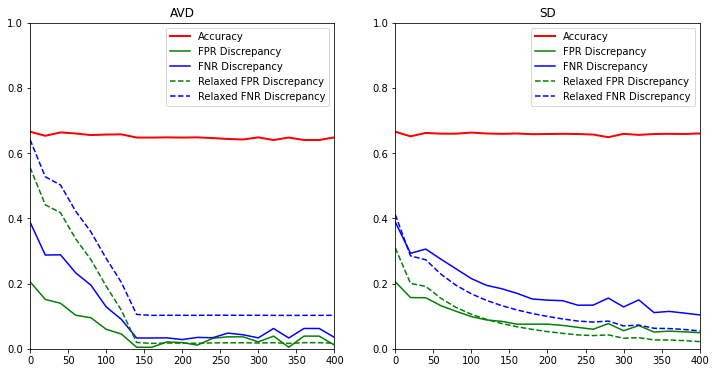

In [214]:
%matplotlib inline

plot_stats(problem['compas'], compas_results,'Compas')

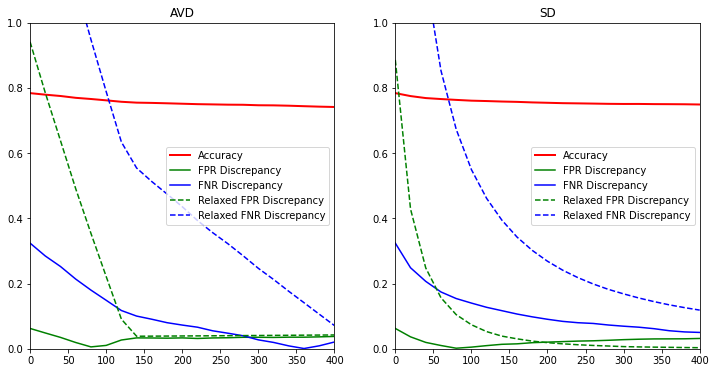

In [24]:
%matplotlib inline

plot_stats(problem['adult'], adult_results,'Adult')